In [99]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import colormaps
from scipy.stats import chi2

#Load data into python (1.1)
AtlasPt1 = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, usecols = 0, delimiter=",") #Pt
AtlasPt2 = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, usecols = 1, delimiter=",") #Pt
AtlasEta1 = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, usecols = 2, delimiter=",") #η
AtlasEta2 = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, usecols = 3, delimiter=",") #η
AtlasPhi1 = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, usecols = 4, delimiter=",") #ϕ
AtlasPhi2 = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, usecols = 5, delimiter=",") #ϕ
AtlasE1 = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, usecols = 6, delimiter=",") #Energy
AtlasE2 = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, usecols = 7, delimiter=",") #Energy

### Part 1

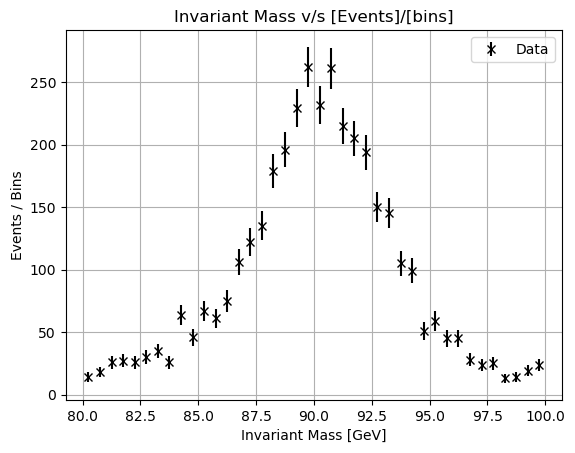

In [130]:
#Calulate Px, Py, Pz, and E
def calc_components(pt, eta, phi, m=0.51099895000):  
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2 + m**2)
    return px, py, pz, E

# Assign values
px1, py1, pz1, e1 = calc_components(AtlasPt1, AtlasEta1, AtlasPhi1)
px2, py2, pz2, e2 = calc_components(AtlasPt2, AtlasEta2, AtlasPhi2)

px_tot = px1 + px2
py_tot = py1 + py2
pz_tot = pz1 + pz2
e_tot = e1 + e2

# calculate the mass of a hypothetical particle which decayed to produce that pair 
mass = np.sqrt(e_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

bins = np.linspace(80, 100, 41)  
bin_centers = 0.5 * (bins[:-1] + bins[1:])
counts, _ = np.histogram(mass, bins=bins)
errors = np.sqrt(counts)  # Poisson errors

# Histogram 
fig, ax = plt.subplots()
ax.errorbar(bin_centers, counts, yerr=errors, fmt='x', color='black', label='Data')
ax.set_xlabel("Invariant Mass [GeV]")
ax.set_ylabel("Events / Bins")
ax.set_title("Invariant Mass v/s [Events]/[bins]")
ax.grid(True)
ax.legend();
plt.savefig("Part 1 Graph");

### Part 2

Chi-squared: 8.559449384721141
Reduced Chi-squared: 0.8559449384721141
p-value: 0.5743597183715434
Best-fit mass: 90.35471532543268 ± 0.0935059492357331 GeV
NDOF: 10


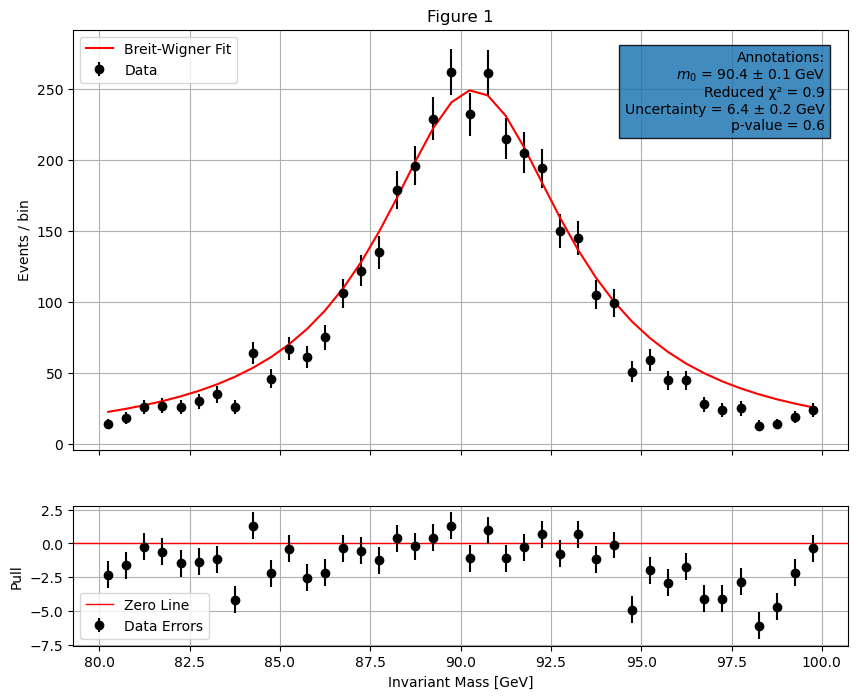

In [141]:
# numpy mask et all
fit_mask = (bin_centers > 87) & (bin_centers < 93)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]
yerr_fit = errors[fit_mask]

# returns the decay distribution as a function of m, m0, and Γ (2.1)
def breit_wigner(m, m0, gamma):
    return 2500 * (1/np.pi)*((gamma / 2) / ((m - m0)**2 + (gamma / 2)**2))

# curve fit
popt, pcov = curve_fit(breit_wigner, x_fit, y_fit, p0=[91.2, 2.5], sigma=yerr_fit, absolute_sigma=True)
m0_fit, gamma_fit = popt
m0_err, gamma_err = np.sqrt(np.diag(pcov))

# Get values for stats
fit_vals = breit_wigner(bin_centers, *popt)
chi2_val = np.sum(((y_fit - breit_wigner(x_fit, *popt)) / yerr_fit)**2)
ndof = len(x_fit) - len(popt)
red_chi2_val = chi2_val/ndof
p_val = chi2.sf(chi2_val, ndof)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]})

# Top Graph
ax1.errorbar(bin_centers, counts, yerr=errors, fmt='o', label='Data', color='black')
ax1.plot(bin_centers, fit_vals, color='red', label='Breit-Wigner Fit')
ax1.set_ylabel("Events / bin")
ax1.set_title("Figure 1")
ax1.legend()
ax1.grid(True)

# Top Text (f-strings suck)
textstr = '\n'.join((
    f'Annotations:',
    f'$m_0$ = {m0_fit:.1f} ± {m0_err:.1f} GeV',  #mass
    f'Reduced χ² = {red_chi2_val:.1f}',   # Reduced Chi2
    f'Uncertainty = {gamma_fit:.1f} ± {gamma_err:.1f} GeV',  #uncertainty
    f'p-value = {p_val:.1f}')) # pval
ax1.text(0.97, 0.95, textstr, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(alpha=0.85))

# Bottom Graph
residuals = (counts - fit_vals) / errors
ax2.axhline(0, color='red', lw=1, label='Zero Line')
ax2.errorbar(bin_centers, residuals, yerr=1, fmt='o', color='black', label="Data Errors")
ax2.set_xlabel("Invariant Mass [GeV]")
ax2.set_ylabel("Pull")
ax2.grid(True)
ax2.legend()
plt.savefig("Part 2 Graph")

#Just in case 
print("Chi-squared:", chi2_val)
print("Reduced Chi-squared:", chi2_val/ndof)
print("p-value:", p_val)
print("Best-fit mass:", m0_fit,"±",m0_err,"GeV")
print("NDOF:", ndof)

### Part 3

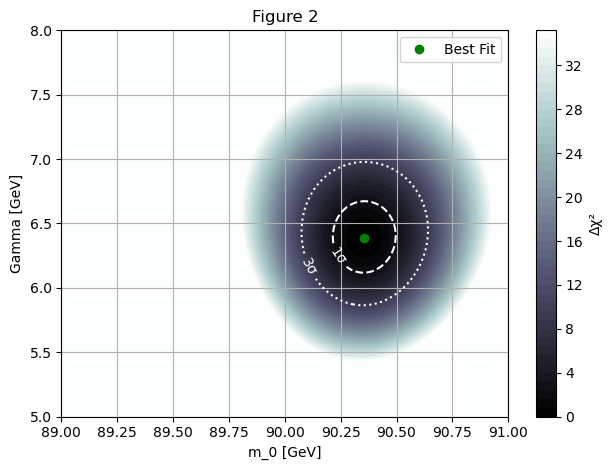

In [148]:
# Start Values
m0_vals = np.linspace(89, 91, 300)
gamma_vals = np.linspace(5.0, 8.0, 300)
M0, G = np.meshgrid(m0_vals, gamma_vals)

# New Values
chi2_grid = np.zeros_like(M0)

for i in range(len(m0_vals)):
    for j in range(len(gamma_vals)):
        model = breit_wigner(x_fit, m0_vals[i], gamma_vals[j])
        chi2_grid[j, i] = np.sum(((y_fit - model) / yerr_fit)**2)

# Grid and Clippping
min_chi2 = np.min(chi2_grid)
chi2_grid = np.clip(chi2_grid, a_min=min_chi2, a_max=min_chi2+35)
delta_chi2 = chi2_grid - min_chi2


# 1σ (68%), 3σ (99%)
levels = [2.30, 9.21]

# Plot
fig, ax = plt.subplots()

cp = plt.contourf(M0, G, delta_chi2, levels=50, cmap='bone')
contours = ax.contour(M0, G, delta_chi2, levels=levels, colors='white', linestyles=['--', ':'])
ax.clabel(contours, fmt={2.30: '1σ', 9.21: '3σ'}, inline=True, fontsize=10)

ax.set_xlabel("m_0 [GeV]")
ax.set_ylabel("Gamma [GeV]")
ax.set_title("Figure 2")
fig.colorbar(cp, label="Δχ²")
ax.grid(True)
fig.tight_layout()
ax.plot(m0_fit, gamma_fit, 'go', label='Best Fit')
ax.legend()
plt.savefig("Part 3 Graph")